# FSRS vs SuperMemo 18

[![open in colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-spaced-repetition/fsrs-vs-sm18/blob/main/compare.ipynb)

In [1]:
username = 'andyjak'
date = '2023-08-11' # YYYY-MM-DD

## 1. SuperMemo Data Filter

This section filters out the repetition history of Concept and Topic. It only keeps the repetition history of Item. It also remove the title of each item for privacy.

You can upload the `Repetition History.txt` file exported from SuperMemo to the following cell. The output will be saved to the same folder as the input file. You can share the output file with others without worrying about privacy. The output file is named `Repetition History-{username}-{date}.txt`.

In [2]:
def correctly_process_file(file_path, output_file_path):
    result_lines = []  # To store the processed lines
    is_item_section = False  # Flag to identify whether we are in an item section

    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            line = line.strip()
            # Check if the line starts a new item section
            if line.startswith('Item #'):
                is_item_section = True
                item_number = line.split(":")[0]  # Keep only the "Item #" part
                result_lines.append(item_number)
            elif line.startswith('Topic #') or line.startswith('Concept #'):
                is_item_section = False
            # If in item section, only keep the repetition records
            elif is_item_section and line.startswith('ElNo'):
                result_lines.append(line)
            elif line.startswith('Repetition') or line.startswith('Date'):
                result_lines.append(line)
            elif is_item_section and line == "":
                result_lines.append(line)

    # Saving the processed content to the output file
    with open(output_file_path, 'w', encoding='utf-8') as file:
        for line in result_lines:
            file.write(line + '\n')


input_file_path = './Repetition History.txt'
output_file_path = f'./Repetition History-{username}-{date}.txt'
correctly_process_file(input_file_path, output_file_path)

## 2. SuperMemo Data Converter

This section converts the SM-18 repetition history to the same format as FSRS.

In [3]:
import pandas as pd
import csv

# Function to extract keys and values from a line
def extract_keys_values(line):
    parts = line.strip().split(" ")
    keys, values = [], []
    for part in parts:
        key, value = part.split("=")
        keys.append(key)
        values.append(value)
    return keys, values

filename = f'Repetition History-{username}-{date}'

# Path to the input TXT file
txt_file_path = f'{filename}.txt'

# Extract all unique keys from the data to form the headers
unique_keys = set()
with open(txt_file_path, 'r', encoding='utf-8') as txt_file:
    for line in txt_file:
        if line.startswith("ElNo"):
            keys, _ = extract_keys_values(line)
            unique_keys.update(keys)

# Sort the keys to maintain a consistent order
headers = sorted(list(unique_keys))

# Path to the output CSV file
csv_file_path = f'{filename}.csv'

# Write the data to CSV with the identified headers and considering missing values
with open(txt_file_path, 'r', encoding='utf-8') as txt_file, open(csv_file_path, 'w', newline='', encoding='utf-8') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(headers)  # Write the headers

    for line in txt_file:
        if line.startswith("ElNo"):
            keys, values = extract_keys_values(line)

            # Consider missing values by aligning with headers
            row = [None] * len(headers)
            for key, value in zip(keys, values):
                index = headers.index(key)
                row[index] = value

            writer.writerow(row)

# Read the CSV file into a DataFrame
df = pd.read_csv(csv_file_path)

# Convert the "Date" column to standard date format
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True).dt.strftime('%Y-%m-%d')

# Sort the DataFrame by "ElNo" and "Date" (ascending for both)
df = df.sort_values(by=['ElNo', 'Date'], ascending=[True, True])

print(f"Number of repetitions: {df.shape[0]}")
print(f"Number of items: {df['ElNo'].unique().shape[0]}")

# Remove unnecessary columns
df.drop(["Difficulty", "Hour", "Postpones", "Priority"], axis=1, inplace=True, errors="ignore")

# Remove items that first row was not the first repetition
df = df.groupby('ElNo').filter(lambda group: (group['Rep'].iloc[0] == 1) and (group['Laps'].iloc[0] == 0))
print(f"Number of repetitions: {df.shape[0]}")

# Remove the first repetition of each item
df.drop(df[(df['Rep'] == 1) & (df['Laps'] == 0)].index, inplace=True)
print(f"Number of repetitions: {df.shape[0]}")

# Remove items that have been reset
df = df.groupby('ElNo').filter(lambda group: (group['Grade'] > 5).sum() == 0)
print(f"Number of repetitions: {df.shape[0]}")

# Remove items that have invalid "expFI" values
df = df.groupby('ElNo').filter(lambda group: (group['expFI'] == 100).sum() == 0)
print(f"Number of repetitions: {df.shape[0]}")

# Keep the first repetitions of the same item on the same day
df.drop_duplicates(subset=['Date', 'ElNo'], keep='first', inplace=True)
print(f"Number of repetitions: {df.shape[0]}")

# Rank the repetitions of each item
df['i'] = df.groupby('ElNo').cumcount() + 1

# Calculate the time difference between repetitions
df['Date'] = pd.to_datetime(df['Date'])
df['delta_t'] = df['Date'].diff().dt.days
df['delta_t'] = df['delta_t'].fillna(0)
df.loc[df['i'] == 1, 'delta_t'] = 0
df['delta_t'] = df['delta_t'].astype(int)

# Rename columns to match FSRS dataset format
df.rename(columns={'ElNo': 'card_id', 'Date': 'review_date'}, inplace=True)

# Convert "Grade" to "review_rating"
# 0, 1, 2 -> 1, 3 -> 2, 4 -> 3, 5 -> 4
df['review_rating'] = df['Grade'].map({0: 1, 1: 1, 2: 1, 3: 2, 4: 3, 5: 4})
df['review_time'] = 0


# Create "t_history" and "r_history" features for training FSRS
from itertools import accumulate

def cum_concat(x):
    return list(accumulate(x))

t_history = df.groupby('card_id', group_keys=False)['delta_t'].apply(lambda x: cum_concat([[int(i)] for i in x]))
df['t_history']=[','.join(map(str, item[:-1])) for sublist in t_history for item in sublist]
r_history = df.groupby('card_id', group_keys=False)['review_rating'].apply(lambda x: cum_concat([[i] for i in x]))
df['r_history']=[','.join(map(str, item[:-1])) for sublist in r_history for item in sublist]

# Create "y" label for training FSRS
df['y'] = df['review_rating'].map(lambda x: {1: 0, 2: 1, 3: 1, 4: 1}[x])

# Remove outliers
def remove_outliers(group: pd.DataFrame) -> pd.DataFrame:
    # threshold = np.mean(group['delta_t']) * 1.5
    # threshold = group['delta_t'].quantile(0.95)
    Q1 = group['delta_t'].quantile(0.25)
    Q3 = group['delta_t'].quantile(0.75)
    IQR = Q3 - Q1
    threshold = Q3 + 1.5 * IQR
    group = group[group['delta_t'] <= threshold]
    return group

df[df['i'] == 2] = df[df['i'] == 2].groupby(by=['r_history', 't_history'], as_index=False, group_keys=False).apply(remove_outliers)
df.dropna(inplace=True)
print(f"Number of repetitions: {df.shape[0]}")

def remove_non_continuous_rows(group):
    discontinuity = group['i'].diff().fillna(1).ne(1)
    if not discontinuity.any():
        return group
    else:
        first_non_continuous_index = discontinuity.idxmax()
        return group.loc[:first_non_continuous_index-1]

df = df.groupby('card_id', as_index=False, group_keys=False).apply(remove_non_continuous_rows)
print(f"Number of repetitions: {df.shape[0]}")

# Save the final dataset
df.to_csv('revlog_history.tsv', sep="\t", index=False)

Number of repetitions: 10178
Number of items: 2123
Number of repetitions: 9546
Number of repetitions: 7387
Number of repetitions: 6386
Number of repetitions: 6386
Number of repetitions: 6377
Number of repetitions: 6286
Number of repetitions: 6270


## 3. Train & Compare

In [4]:
%pip install -q FSRS-Optimizer==4.9.0
import fsrs_optimizer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fsrs_optimizer import plot_brier
from sklearn.metrics import mean_squared_error

revlogs = pd.read_csv('revlog_history.tsv', sep='\t', keep_default_na=False)
revlogs = revlogs[(revlogs['i'] > 1) & (revlogs['delta_t'] > 0) & (revlogs['t_history'].str.count(',0') == 0)]

optimizer = fsrs_optimizer.Optimizer()

S0_dataset = revlogs[revlogs['i'] == 2]
optimizer.S0_dataset_group = S0_dataset.groupby(by=['r_history', 'delta_t'], group_keys=False).agg({'y': ['mean', 'count']}).reset_index()

optimizer.define_model()
optimizer.pretrain(verbose=False)
optimizer.train(verbose=False)
print(optimizer.w)

Note: you may need to restart the kernel to use updated packages.
Pretrain finished!


  0%|          | 0/4415 [00:00<?, ?it/s]

Tensorized!
TRAIN: 2558 TEST: 1857
dataset built


train:   0%|          | 0/10970 [00:00<?, ?it/s]

TRAIN: 3655 TEST: 760
dataset built


train:   0%|          | 0/10960 [00:00<?, ?it/s]

TRAIN: 3783 TEST: 632
dataset built


train:   0%|          | 0/10955 [00:00<?, ?it/s]

TRAIN: 3803 TEST: 612
dataset built


train:   0%|          | 0/10925 [00:00<?, ?it/s]

TRAIN: 3861 TEST: 554
dataset built


train:   0%|          | 0/10910 [00:00<?, ?it/s]


Training finished!
[5.0989, 72.4736, 107.2543, 107.2543, 4.5323, 0.6283, 0.6445, 0.2029, 1.906, 0.1, 1.3437, 2.3034, 0.0341, 0.4395, 1.3331, 0.6296, 2.7995]


In [5]:
loss_before, loss_after = optimizer.evaluate()
print(f"Loss before training: {loss_before:.4f}")
print(f"Loss after training: {loss_after:.4f}")

Loss before training: 0.2152
Loss after training: 0.1965


R-squared: 0.1561
RMSE: 0.0359
MAE: 0.0179
[0.42211095 0.56021216]

Last rating: 1
R-squared: 0.5395
RMSE: 0.0943
MAE: 0.0431
[-0.12641481  1.11309219]

Last rating: 2
R-squared: -0.6115
RMSE: 0.0829
MAE: 0.0580
[0.73022039 0.20019074]

Last rating: 3
R-squared: -1.1532
RMSE: 0.0364
MAE: 0.0182
[0.64736545 0.32737798]

Last rating: 4
R-squared: -0.1196
RMSE: 0.0408
MAE: 0.0263
[0.4605166 0.5379992]


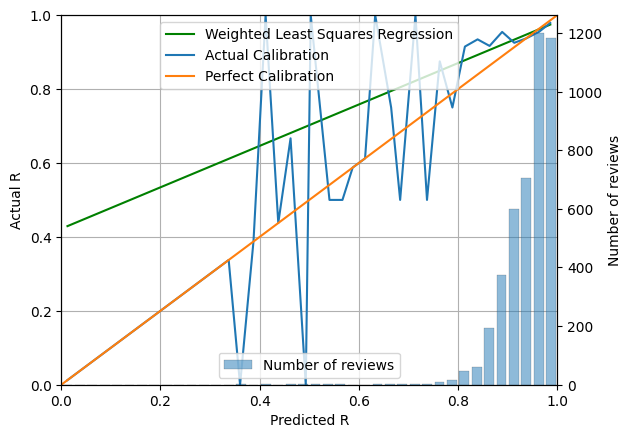

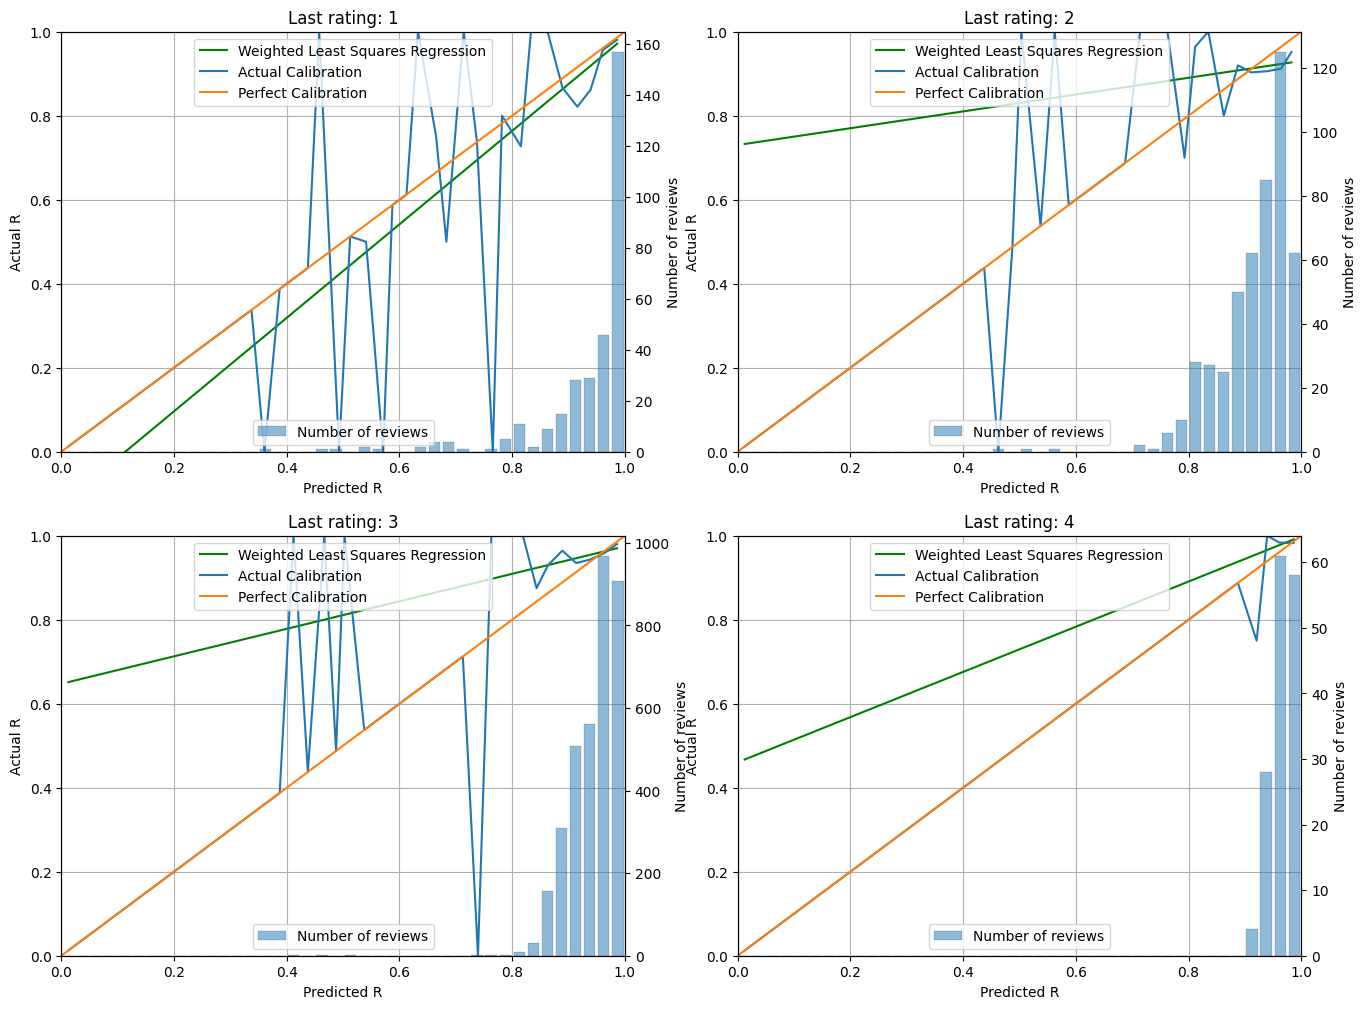

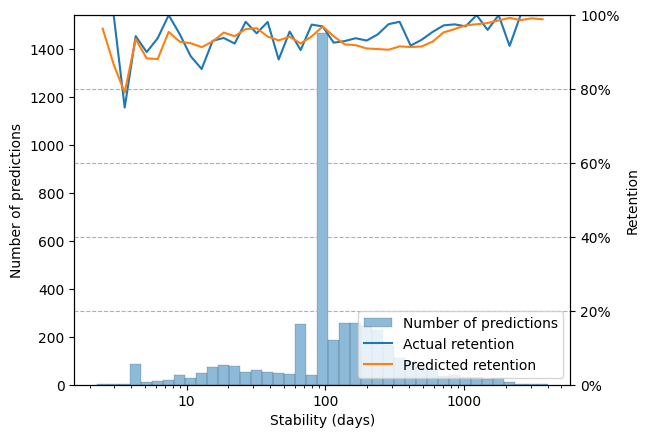

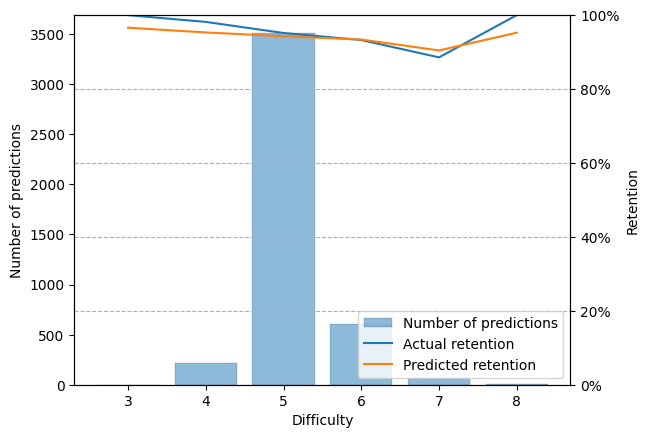

In [6]:
fsrs_metrics, _ = optimizer.calibration_graph()

Loss of SM-2: 2.5481
R-squared: -825.6353
RMSE: 0.7335
MAE: 0.6694
[0.94080528 0.0310027 ]
Universal Metric of FSRS: 0.0227
Universal Metric of SM2: 0.6814


(<Figure size 640x480 with 2 Axes>, <Figure size 600x600 with 1 Axes>)

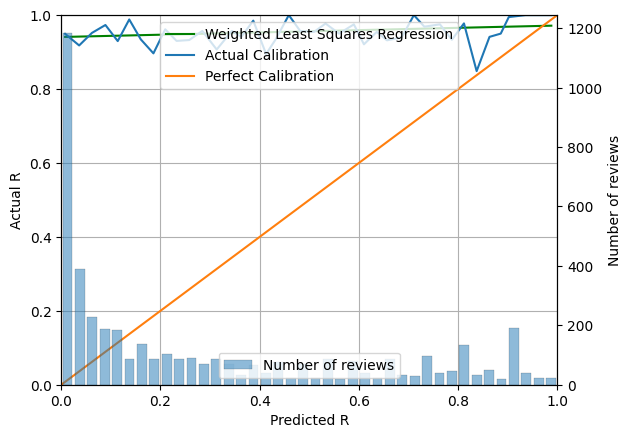

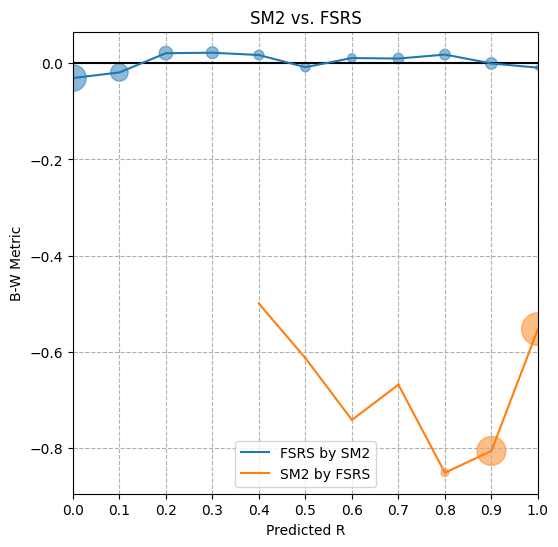

In [7]:
optimizer.compare_with_sm2()

Loss of SM-18: 0.2403
R-squared: -6.0292
RMSE: 0.1168
MAE: 0.0621
[0.7347366  0.24178803]
Universal Metric of FSRS: 0.0184
Universal Metric of SM18: 0.0750


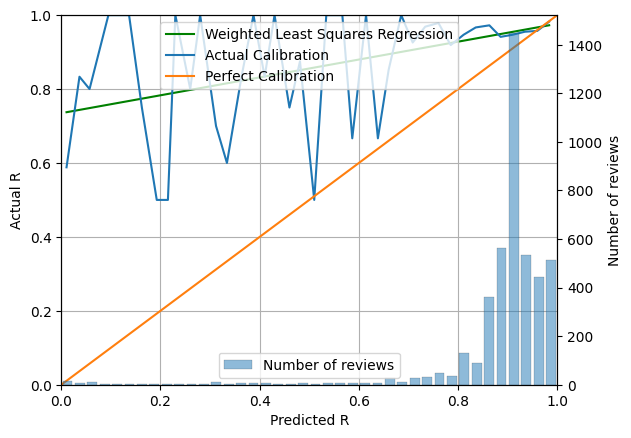

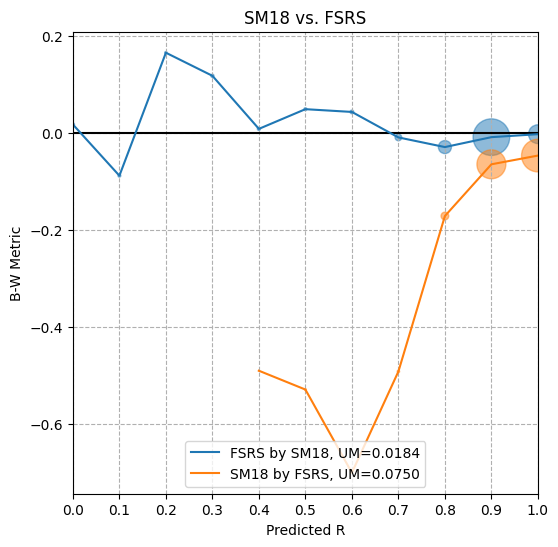

In [8]:
revlogs['p'] = optimizer.dataset['p']
revlogs['sm18_p'] = 1 - revlogs['expFI'] / 100
revlogs['log_loss'] = revlogs.apply(lambda row: - np.log(row['sm18_p']) if row['y'] == 1 else - np.log(1 - row['sm18_p']), axis=1)
print(f"Loss of SM-18: {revlogs['log_loss'].mean():.4f}")
cross_comparison = revlogs[['sm18_p', 'p', 'y']].copy()
fig1 = plt.figure()
sm18_metrics = plot_brier(cross_comparison['sm18_p'], cross_comparison['y'], bins=40, ax=fig1.add_subplot(111))
fig1.show()

fig2 = plt.figure(figsize=(6, 6))
ax = fig2.gca()

cross_comparison['SM18_B-W'] = cross_comparison['sm18_p'] - cross_comparison['y']
cross_comparison['SM18_Bin'] = cross_comparison['sm18_p'].map(lambda x: round(x, 1))
cross_comparison['FSRS_B-W'] = cross_comparison['p'] - cross_comparison['y']
cross_comparison['FSRS_bin'] = cross_comparison['p'].map(lambda x: round(x, 1))

ax.axhline(y = 0.0, color = 'black', linestyle = '-')

cross_comparison_group = cross_comparison.groupby(by='SM18_Bin').agg({'y': ['mean'], 'FSRS_B-W': ['mean'], 'p': ['mean', 'count']})
universal_metric = mean_squared_error(cross_comparison_group['y', 'mean'], cross_comparison_group['p', 'mean'], sample_weight=cross_comparison_group['p', 'count'], squared=False)
fsrs_metrics['universal_metric'] = universal_metric
print(f"Universal Metric of FSRS: {universal_metric:.4f}")
cross_comparison_group['p', 'percent'] = cross_comparison_group['p', 'count'] / cross_comparison_group['p', 'count'].sum()
ax.scatter(cross_comparison_group.index, cross_comparison_group['FSRS_B-W', 'mean'], s=cross_comparison_group['p', 'percent'] * 1024, alpha=0.5)
ax.plot(cross_comparison_group['FSRS_B-W', 'mean'], label=f'FSRS by SM18, UM={universal_metric:.4f}')

cross_comparison_group = cross_comparison.groupby(by='FSRS_bin').agg({'y': ['mean'], 'SM18_B-W': ['mean'], 'sm18_p': ['mean', 'count']})
universal_metric = mean_squared_error(cross_comparison_group['y', 'mean'], cross_comparison_group['sm18_p', 'mean'], sample_weight=cross_comparison_group['sm18_p', 'count'], squared=False)
sm18_metrics['universal_metric'] = universal_metric
print(f"Universal Metric of SM18: {universal_metric:.4f}")
cross_comparison_group['sm18_p', 'percent'] = cross_comparison_group['sm18_p', 'count'] / cross_comparison_group['sm18_p', 'count'].sum()
ax.scatter(cross_comparison_group.index, cross_comparison_group['SM18_B-W', 'mean'], s=cross_comparison_group['sm18_p', 'percent'] * 1024, alpha=0.5)
ax.plot(cross_comparison_group['SM18_B-W', 'mean'], label=f'SM18 by FSRS, UM={universal_metric:.4f}')

ax.legend(loc='lower center')
ax.grid(linestyle='--')
ax.set_title("SM18 vs. FSRS")
ax.set_xlabel('Predicted R')
ax.set_ylabel('B-W Metric')
ax.set_xlim(0, 1)
ax.set_xticks(np.arange(0, 1.1, 0.1))

fig2.show()

In [9]:
{
    'user': username,
    'size': len(revlogs),
    'fsrs': fsrs_metrics,
    'sm18': sm18_metrics
}

{'user': 'andyjak',
 'size': 4415,
 'fsrs': {'R-squared': 0.15611401632776012,
  'RMSE': 0.03586262985554867,
  'MAE': 0.017922074973988854,
  'universal_metric': 0.018412121741445835},
 'sm18': {'R-squared': -6.029222114617728,
  'RMSE': 0.11684639185576796,
  'MAE': 0.062074745186861756,
  'universal_metric': 0.07503735502480205}}